In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import tensorflow as tf
import pickle
import numpy as np
import os

def load_obj(name, direct):
    'Helper function using pickle to save and load objects'
    with open("../data/external/" + direct + "/" + name, "rb") as f:
        d =  pickle.load(f, encoding='latin1')
        return d
    
def chunks(l, n):
    chunked = np.empty([3, 3, 6])
    for i in range(0, 54, n):
        reshaped = np.reshape(l[i:i + n], (3, 3))
        chunked[0:3, 0:3, i//n] = reshaped
    return chunked

def data_generator(files, direct):
    while True:
        i = 0
        for file in files:
            i += 1
            f = load_obj(file, direct)
            x_begin = f[0][:, :, 1:]
            x_end = np.empty([500, 26, 3, 3, 6])
            for i in range(len(x_begin)):               # for i in 0:500
                for j in range(len(x_begin[i])):        # for j in 0:26
                    chk = chunks(x_begin[i, j, :], 9)
                    x_end[i, j, 0:3, 0:3, 0:6] = chk
            yield x_end, f[1], f[2]

In [3]:
from sklearn.utils.class_weight import compute_class_weight
weights_all = []
for i in range(0, 50):  
    x, y, seq_lengths = (next(data_generator(os.listdir("../data/external/train"), "train")))
    tst = np.argmax(np.reshape(y, (500*26, 23)), 1)
    lengths_transposed = np.expand_dims(seq_lengths, 1)
    rng = np.arange(0, 26, 1)
    range_row = np.expand_dims(rng, 0)
    masked = np.less(range_row, lengths_transposed)
    masked = np.reshape(masked, (500*26))
    masked = masked.astype(int)
    weights_all.append(tst)
weights_all = [item for sublist in weights_all for item in sublist]
weights_crop = [x for x in weights_all if x > 3]
weight = compute_class_weight(classes = np.unique(weights_all), y = weights_all, class_weight ='balanced')
weight_crop = compute_class_weight(classes = np.unique(weights_crop), y = weights_crop, class_weight = 'balanced')
print(weight)
print(weight_crop)

[8.02068102e-02 2.97482838e+01 6.57229525e+00 2.03315608e+00
 2.89261715e-01 5.61846313e-01 6.89289502e-01 8.07453416e+01
 5.43478261e+00 4.95804729e+00 7.06521739e+01 9.91609458e+00
 1.41304348e+01 8.61611877e-01 1.44556878e+00 1.28458498e+01
 1.25603865e+01 7.06521739e+00 1.31445905e+01 2.97482838e+01
 4.87256372e+00 1.94902549e+01 1.52761457e+01]
[ 0.15002963  0.29140944  0.35750963 41.87969925  2.81882591  2.57156048
 36.64473684  5.14312096  7.32894737  0.44688703  0.74976444  6.66267943
  6.51461988  3.66447368  6.81762546 15.42936288  2.52722323 10.10889292
  7.92318634]


In [41]:
import random

tf.reset_default_graph()

batch_size = 50
lstm_size = 240
n_steps = 26
num_input = 54
learning_rate = 1e-3
dim_capsule = 10
n_classes = 23

args_dict = {'Batch size' : batch_size, 
            'LSTM size' : lstm_size,
            'Dim capsule' : dim_capsule,
            'Learning rate' : learning_rate}

# [batch, in_depth, in_height, in_width, in_channels].
X = tf.placeholder(tf.float32, shape=(batch_size, n_steps, 3, 3, 6))
y = tf.placeholder(tf.float32, shape=(batch_size, n_steps, n_classes))
seq_lengths = tf.placeholder(tf.int32, [batch_size], name="seq_lengths")

def create_weights(shape, initializer = 'xavier'):
    initializer = tf.contrib.layers.xavier_initializer()
    if initializer != 'xavier':
        initializer = initializers.get('glorot_uniform')
    return(tf.Variable(initializer(shape)))
 
def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

def create_convolutional_layer(input):  
 
    print("Conv input shape: {}".format(input.shape))
    layers = []
    layer0 = tf.layers.conv2d(inputs=input[:, 0, :, :, :],
                         filters=80,
                         kernel_size = 1,
                         strides=[1, 1],
                         padding='valid',
                              activation = tf.nn.relu,
                              name = 'convolution1')
    layer0 = tf.reshape(layer0, (-1, 3, 3, 80))
    layer0 = tf.layers.max_pooling2d(layer0, pool_size = 2, strides = 1)
    layers.append(layer0)
    for i in range(1, 26):
    ## Creating the convolutional layer
        layer = tf.layers.conv2d(inputs=input[:, i, :, :, :],
                         filters=80,
                         kernel_size = 1,
                         strides=[1, 1],
                         padding='valid',
                         activation = tf.nn.relu,
                                 reuse = True,
                         name = 'convolution1',
                         )

        layer = tf.reshape(layer, (-1, 3, 3, 80))
        layer = tf.layers.max_pooling2d(layer, pool_size = 2, strides = 1)
        layers.append(layer)
    
    output = tf.stack(layers, axis = 1)
    print("Conv output shape: {}".format(output.shape))
    return output

def create_lstm(x, seq_length):
    print("LSTM input shape: {}".format(x.shape))
    lstm_cell_fw = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, state_is_tuple = True)
    lstm_cell_bw = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, state_is_tuple = True)
    states, final_state = tf.nn.bidirectional_dynamic_rnn(
                                        cell_fw = lstm_cell_fw, 
                                        cell_bw = lstm_cell_bw,
                                        inputs = x, 
                                        dtype = tf.float32,
                                        time_major = False,
                                        sequence_length=seq_length)
    print("LSTM out shape: {}".format(states[0].shape))
    output = tf.concat([states[0], states[1]], axis = 2)
    print("LSTM final shape: {}".format(output.shape))
    return output

def create_deep_lstm(x, seq_length):
    print("Deep LSTM input: {}".format(x.shape))
    with tf.name_scope('RNN'):
        #cell = tf.nn.rnn_cell.LSTMCell(n_rnn_cells)
        #cell = tf.contrib.rnn.DropoutWrapper(cell=cell, output_keep_prob= 1)
        #cell = tf.nn.rnn_cell.MultiRNNCell([cell] * 3)
        def lstm_cell():
            return tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        cells_fw = [lstm_cell() for _ in range(2)]
        print(cells_fw)
        cells_bw = [lstm_cell() for _ in range(2)]
        #state_fw = cells_fw[0].zero_state(batch_size, tf.float32)
        #state_bw = cells_bw[0].zero_state(batch_size, tf.float32)
        
        outputs, last_states, _ = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
            cells_fw = cells_fw,
            cells_bw = cells_bw,
            inputs = x,
            #initial_states_fw = state_fw,
            #initial_states_bw = state_bw,
            dtype=tf.float32,
            sequence_length=seq_length,
        )
        #stacked_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(2)])
        #state = stacked_lstm.zero_state(batch_size, tf.float32)
        #outputs, last_states = tf.nn.dynamic_rnn(stacked_lstm, x,
        #                                         initial_state=state, sequence_length=seq_length,
        #                                                 time_major=False)
        #output = tf.concat([outputs[0], outputs[1]], axis = 2)
        print("Deep LSTM out: {}".format(outputs.shape))
        print("Deep LSTM concat: {}".format(outputs.shape))

        return outputs

def distributed_dense(x, units, activation, name):
    print("Dense in: {}".format(x.shape))
    dense_layers = []
    for i in range(0, n_steps):
        data = tf.squeeze(x[:, i, :])
        if i == 0:
            dense_l = tf.layers.dense(data,
                                    units,
                                    activation,
                                   name = name,
                                    reuse = False)
        else: 
            dense_l = tf.layers.dense(data,
                                    units,
                                    activation,
                                   name = name,
                                    reuse = True)
        dense_layers.append(dense_l)
    dense_layers = tf.stack(dense_layers, axis = 1)
    print("Dense out: {}".format(dense_layers.shape))
    return dense_layers

In [42]:
import keras.backend as K
from keras import initializers, layers

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = 23
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding, i):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    if i == 0:
        output = tf.layers.conv2d(inputs, filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d', reuse = None)
    else: 
        output = tf.layers.conv2d(inputs, filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d', reuse = True)
    
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

def multi_capsule(x):
    n_channels = 64
    caps = CapsuleLayer(num_capsule = n_classes, dim_capsule=dim_capsule, routings=4, name='digitcaps')
    #primary_layers = []
    caps_layers = []
    for i in range(0, n_steps):
        xi = tf.squeeze(x[:, i, :, :, :])
        primarycaps = PrimaryCap(xi, dim_capsule=dim_capsule, n_channels=n_channels, kernel_size=3, strides=1, padding='valid', i = i)
        if i == 0:
            print("Primary cap squeeze shape: {}".format(primarycaps.shape))
        caps_layer = caps(primarycaps) 
        caps_layers.append(caps_layer)
    output = tf.stack(caps_layers, axis = 1)
    #output = tf.reshape(output, (batch_size, 23*8))
    print("Capsule out: {}".format(output.shape))
    return output


def create_multi_attention(inputs, attention_size, time_major=False):
    hidden_size = inputs.shape[2].value
    print("Attention In: {}".format(inputs.shape))
   
    w_omegas, b_omegas, u_omegas = [], [], []
    for i in range(0, 26):
        w_omegas.append(create_weights([hidden_size, attention_size]))
        b_omegas.append(tf.Variable(tf.constant(0.05, shape = [attention_size])))
        u_omegas.append(create_weights([attention_size]))
        
    # Trainable parameters
    layers_all = []
    for i in range(0, 26):  
        v = tf.tanh(tf.tensordot(inputs, w_omegas[i], axes=1) + b_omegas[i])       
        # For each of the timestamps its vector of size A from `v` is reduced with `u` vector
        vu = tf.tensordot(v, u_omegas[i], axes=1, name='vu')  # (B,T) shape\
        alphas = tf.nn.softmax(vu, name='alphas')         # (B,T) shape

        # Output of (Bi-)RNN is reduced with attention vector; the result has (B,D) shape
        output = tf.reshape(tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1), (batch_size, 1, hidden_size))
        
        layers_all.append(output)
    output = tf.concat(layers_all, axis = 1)
    print("Attention Out: {}".format(output.shape))
    return output

In [43]:
from sklearn import metrics
def crop_net(x, attention = True, skip = True):  
    conv1 = create_convolutional_layer(input = x)
    #capsule = multi_capsule(conv1)
    conv_reshape = tf.reshape(conv1, (-1, n_steps, 2*2*80))
    #capsule_reshape = tf.reshape(capsule, (-1, n_steps, 23*dim_capsule))
    lstm_out = create_lstm(conv_reshape, seq_lengths)
    #lstm_out = create_deep_lstm(capsule_reshape, seq_lengths)
    #attention = create_multi_attention(lstm_out, 150)
    #attention_concat = tf.concat(attention, capsule_reshape, axis = 3)

    #dense1 = distributed_dense(attention, 512, tf.nn.relu, "dense1")
    dense2 = distributed_dense(lstm_out, 512, tf.nn.relu, "dense2")
    dense3 = distributed_dense(dense2, 23, None, "dense3")
    dense3 = tf.reshape(dense3, (batch_size*26, 23))
    return dense3

def make_confusion_plot(confusion):
    confusion2 = np.zeros((23, 23))
    for i, row in enumerate(confusion):
        confusion2[i] = row / np.maximum(1, np.sum(row))
    plt.clf()
    sns.heatmap(confusion2.T, cmap = plt.cm.Blues)
    plt.show()
    
    
def one_hot(a, num_classes):
    a = np.asarray(a)
    b = np.zeros((len(a), num_classes))
    b[np.arange(len(a)), a] = 1
    return(b)
    
def calc_crop_acc(pred, true, class_weight):
    index = [index for index, value in enumerate(true) if value > 3]
    true_crop = np.asarray([true[i] - 4 for i in index])
    pred_crop = np.asarray([pred[i] - 4 for i in index])
    #true_onehot = one_hot(true_crop, 19)
    #weighted = np.sum(true_onehot * class_weight, axis = 1)
    
    w_field = np.ones(true_crop.shape[0])
    for idx, i in enumerate(np.bincount(true_crop)):
        w_field[true_crop == idx] *= (i/float(true_crop.shape[0]))
    accuracy_sc = metrics.accuracy_score(true_crop, pred_crop, sample_weight=w_field)
    
    true_ar = np.asarray(true)
    pred_ar = np.asarray(pred)
    w_all = np.ones(true_ar.shape[0])
    for idx, i in enumerate(np.bincount(true_ar)):
        w_all[true_ar == idx] *= (i/float(true_ar.shape[0]))
    acc_sc_all = metrics.accuracy_score(true_ar, pred_ar, sample_weight=w_all)
    
    
    print("Weighted P R F S {}".format(metrics.precision_recall_fscore_support(true_crop, pred_crop, average = 'weighted')))
    #print("Balanced crop accuracy {}".format(metrics.accuracy_score(true_crop, pred_crop, True, weighted)))
    print("Crop accuracy: {}".format(np.mean(np.equal(true_crop, pred_crop))))
    print("Weighted crop accuracy {}".format(accuracy_sc))
    print("weighted all accuracy: {} ".format(acc_sc_all))

In [44]:
# Construct model
logits = crop_net(X)
print("Logits shape: {}".format(logits.shape))

y_pred = tf.nn.softmax(logits)
y_out = tf.reshape(y, (batch_size*26, 23))

lengths_transposed = tf.expand_dims(seq_lengths, 1)
rng = tf.range(0, 26, 1)
range_row = tf.expand_dims(rng, 0)
mask_boolean = tf.reshape(tf.less(range_row, lengths_transposed), (batch_size*26,))
mask = tf.cast(mask_boolean, tf.float32)

class_weights = tf.constant(weight, dtype = tf.float32) 
print("Class weights: {}".format(weight))
weight_map = tf.multiply(y_out, class_weights)
weight_map = tf.reduce_sum(weight_map, axis=1)

cross_entropy_matrix = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels= y_out)
print("Cross entropy size: {}".format(cross_entropy_matrix.shape))
weighted_losses = cross_entropy_matrix * mask # weight_map
cross_entropy = tf.reduce_sum(weighted_losses) / tf.cast(tf.reduce_sum(seq_lengths), tf.float32)
print("Final loss shape: {}".format(cross_entropy.shape))

# Define loss and optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(weighted_losses)

y_pred = tf.boolean_mask(tf.argmax(tf.nn.softmax(logits), 1), mask_boolean)
y_true = tf.boolean_mask(tf.argmax(y_out, 1), mask_boolean)
accuracy_vector = tf.equal(y_pred, y_true)
accuracy = tf.reduce_mean(tf.cast(accuracy_vector, tf.float32))

Conv input shape: (50, 26, 3, 3, 6)
Conv output shape: (50, 26, 2, 2, 80)
LSTM input shape: (50, 26, 320)
LSTM out shape: (50, 26, 240)
LSTM final shape: (50, 26, 480)
Dense in: (50, 26, 480)
Dense out: (50, 26, 512)
Dense in: (50, 26, 512)
Dense out: (50, 26, 23)
Logits shape: (1300, 23)
Class weights: [8.02068102e-02 2.97482838e+01 6.57229525e+00 2.03315608e+00
 2.89261715e-01 5.61846313e-01 6.89289502e-01 8.07453416e+01
 5.43478261e+00 4.95804729e+00 7.06521739e+01 9.91609458e+00
 1.41304348e+01 8.61611877e-01 1.44556878e+00 1.28458498e+01
 1.25603865e+01 7.06521739e+00 1.31445905e+01 2.97482838e+01
 4.87256372e+00 1.94902549e+01 1.52761457e+01]
Cross entropy size: (1300,)
Final loss shape: ()


Batch size: 50
LSTM size: 240
Dim capsule: 10
Learning rate: 0.001
Model restored.
Batch 50: Training accuracy: 0.554344117641449 Loss: 1.5420234203338623
Batch 100: Training accuracy: 0.632727861404419 Loss: 1.1779773235321045
Batch 150: Training accuracy: 0.7253907918930054 Loss: 0.940798282623291
Batch 200: Training accuracy: 0.7785999774932861 Loss: 0.7759650945663452
Batch 250: Training accuracy: 0.7974512577056885 Loss: 0.7141126990318298
Test accuracy: 0.7962703704833984
Weighted P R F S (0.6587452810890635, 0.6523425326361716, 0.6426008555484068, None)
Crop accuracy: 0.6523425326361716
Weighted crop accuracy 0.7689270846882106
weighted all accuracy: 0.9149805940729102 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


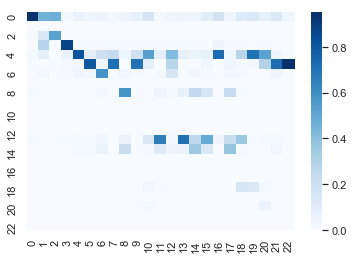

Batch 300: Training accuracy: 0.8160058856010437 Loss: 0.6509837508201599
Batch 350: Training accuracy: 0.816690981388092 Loss: 0.6473188996315002
Batch 400: Training accuracy: 0.819119930267334 Loss: 0.6263996362686157
Batch 450: Training accuracy: 0.8384031653404236 Loss: 0.5909879803657532
Batch 500: Training accuracy: 0.8358187079429626 Loss: 0.5710570812225342
Test accuracy: 0.839759111404419
Weighted P R F S (0.7522811473919522, 0.7461847663169369, 0.7429349644408237, None)
Crop accuracy: 0.7461847663169369
Weighted crop accuracy 0.8322749281419862
weighted all accuracy: 0.9249192469298039 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


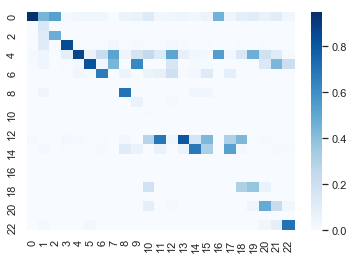

Batch 550: Training accuracy: 0.8391522169113159 Loss: 0.5691669583320618
Batch 600: Training accuracy: 0.8446667194366455 Loss: 0.5542439818382263
Batch 650: Training accuracy: 0.846866250038147 Loss: 0.5398319363594055
Batch 700: Training accuracy: 0.8480876684188843 Loss: 0.5348435044288635
Batch 750: Training accuracy: 0.8509547710418701 Loss: 0.5376176238059998
Test accuracy: 0.8594257235527039
Weighted P R F S (0.801320479284321, 0.7932660379864523, 0.7926465245831936, None)
Crop accuracy: 0.7932660379864523
Weighted crop accuracy 0.858468525112102
weighted all accuracy: 0.9255336844738465 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


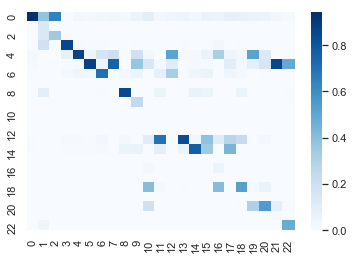

Batch 800: Training accuracy: 0.8540907502174377 Loss: 0.5161784291267395
Batch 850: Training accuracy: 0.862775444984436 Loss: 0.4930305778980255
Batch 900: Training accuracy: 0.8545682430267334 Loss: 0.5062264800071716
Batch 950: Training accuracy: 0.8609657883644104 Loss: 0.5097577571868896
Batch 1000: Training accuracy: 0.8671960234642029 Loss: 0.4691351056098938
Test accuracy: 0.8549272418022156
Weighted P R F S (0.7642594945172109, 0.755045871559633, 0.7532780695647721, None)
Crop accuracy: 0.755045871559633
Weighted crop accuracy 0.8250446213616386
weighted all accuracy: 0.9361734339801695 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


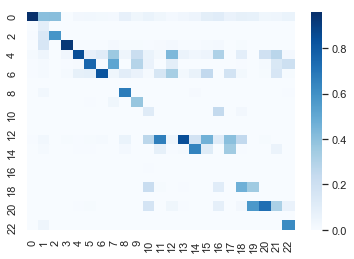

Batch 1050: Training accuracy: 0.8682156205177307 Loss: 0.47427868843078613
Batch 1100: Training accuracy: 0.8597756028175354 Loss: 0.49235352873802185
Batch 1150: Training accuracy: 0.8694514632225037 Loss: 0.47597870230674744
Batch 1200: Training accuracy: 0.864545464515686 Loss: 0.47864264249801636
Batch 1250: Training accuracy: 0.8684684634208679 Loss: 0.4749305248260498
Test accuracy: 0.8721585273742676
Weighted P R F S (0.8193584975175506, 0.7985808956422786, 0.8059919400708536, None)
Crop accuracy: 0.7985808956422786
Weighted crop accuracy 0.8337962308463331
weighted all accuracy: 0.9345887178714487 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


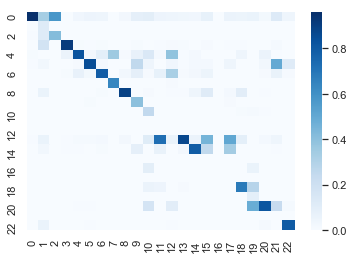

Batch 1300: Training accuracy: 0.864359438419342 Loss: 0.4707925319671631
Batch 1350: Training accuracy: 0.8640708327293396 Loss: 0.4629792869091034
Batch 1400: Training accuracy: 0.8760961294174194 Loss: 0.44331592321395874
Batch 1450: Training accuracy: 0.875547468662262 Loss: 0.4283294975757599
Batch 1500: Training accuracy: 0.8780621886253357 Loss: 0.44409769773483276
Test accuracy: 0.8756495118141174
Weighted P R F S (0.8188245440934855, 0.802133062468258, 0.8054221174346664, None)
Crop accuracy: 0.802133062468258
Weighted crop accuracy 0.8521697950959248
weighted all accuracy: 0.9394088928009824 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


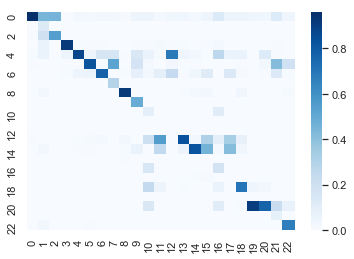

Batch 1550: Training accuracy: 0.874859094619751 Loss: 0.45293647050857544
Batch 1600: Training accuracy: 0.8758425712585449 Loss: 0.43780630826950073
Batch 1650: Training accuracy: 0.879072368144989 Loss: 0.4304365813732147
Batch 1700: Training accuracy: 0.8776128888130188 Loss: 0.44433343410491943
Batch 1750: Training accuracy: 0.8788847923278809 Loss: 0.4415043890476227
Test accuracy: 0.8761512041091919
Weighted P R F S (0.8153405585559013, 0.7962088598805721, 0.8012850694918124, None)
Crop accuracy: 0.7962088598805721
Weighted crop accuracy 0.8337221782549286
weighted all accuracy: 0.942132021272252 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


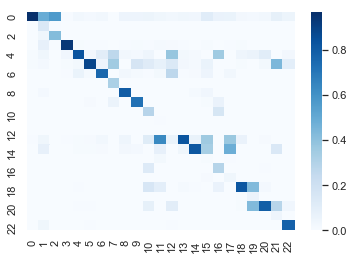

Batch 1800: Training accuracy: 0.8836198449134827 Loss: 0.4360436201095581
Batch 1850: Training accuracy: 0.8823096752166748 Loss: 0.4425833523273468
Batch 1900: Training accuracy: 0.8770883083343506 Loss: 0.44157105684280396
Batch 1950: Training accuracy: 0.8717485070228577 Loss: 0.4364626407623291
Batch 2000: Training accuracy: 0.8785011768341064 Loss: 0.42099761962890625
Test accuracy: 0.8791307806968689
Weighted P R F S (0.8360228962323796, 0.8169647317414327, 0.8218603060300375, None)
Crop accuracy: 0.8169647317414327
Weighted crop accuracy 0.8832559774755236
weighted all accuracy: 0.9383308459116756 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


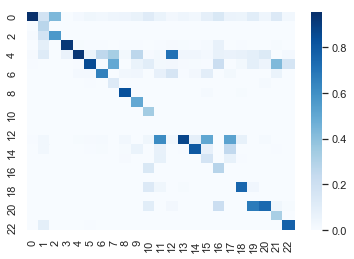

Batch 2050: Training accuracy: 0.8781864643096924 Loss: 0.42000117897987366
Batch 2100: Training accuracy: 0.8789362907409668 Loss: 0.4165603220462799
Batch 2150: Training accuracy: 0.8809021711349487 Loss: 0.4265406131744385
Batch 2200: Training accuracy: 0.8864779472351074 Loss: 0.4063175618648529
Batch 2250: Training accuracy: 0.8865207433700562 Loss: 0.4075303375720978
Test accuracy: 0.8813127279281616
Weighted P R F S (0.8272777824046024, 0.810450500363586, 0.812505805425175, None)
Crop accuracy: 0.810450500363586
Weighted crop accuracy 0.8627659668813077
weighted all accuracy: 0.94645886630792 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


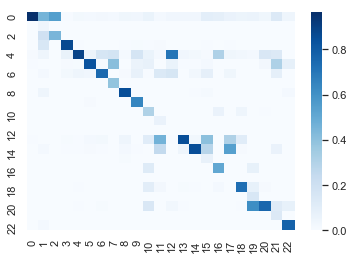

Batch 2300: Training accuracy: 0.8876954913139343 Loss: 0.4066532254219055
Batch 2350: Training accuracy: 0.8822935223579407 Loss: 0.42544540762901306
Batch 2400: Training accuracy: 0.8871996402740479 Loss: 0.4113576412200928
Batch 2450: Training accuracy: 0.893283486366272 Loss: 0.38204896450042725
Batch 2500: Training accuracy: 0.8842326402664185 Loss: 0.39621204137802124
Test accuracy: 0.8824983239173889
Weighted P R F S (0.8355334224267053, 0.814620520506881, 0.8199580505824525, None)
Crop accuracy: 0.814620520506881
Weighted crop accuracy 0.864589026156222
weighted all accuracy: 0.9439243425315043 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


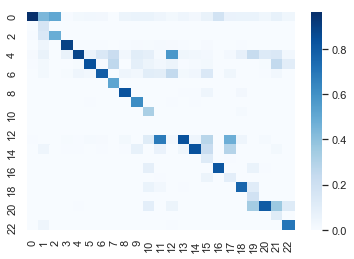

Evaluation accuracy: 0.8764697313308716


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Weighted P R F S (0.815237198648589, 0.7886316871636315, 0.7924308924582459, None)
Crop accuracy: 0.7886316871636315
Weighted crop accuracy 0.8429604313470772
weighted all accuracy: 0.9488285431680846 


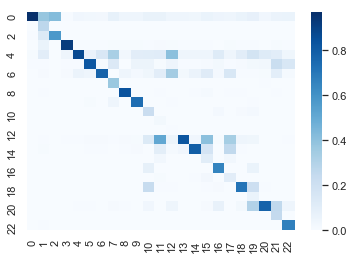

Batch 2550: Training accuracy: 0.8852554559707642 Loss: 0.4079737365245819
Batch 2600: Training accuracy: 0.8865413665771484 Loss: 0.4180014133453369
Batch 2650: Training accuracy: 0.8858916759490967 Loss: 0.41939777135849
Batch 2700: Training accuracy: 0.8871829509735107 Loss: 0.40825310349464417
Batch 2750: Training accuracy: 0.887515127658844 Loss: 0.3990534842014313
Test accuracy: 0.888751208782196
Weighted P R F S (0.8554130175667374, 0.8262717492362863, 0.8333682196718964, None)
Crop accuracy: 0.8262717492362863
Weighted crop accuracy 0.8867616722071854
weighted all accuracy: 0.9532633272975185 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


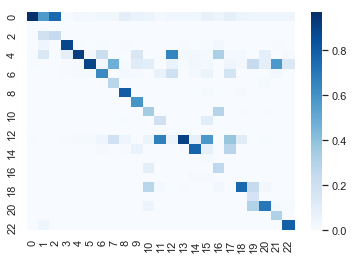

Batch 2800: Training accuracy: 0.886353611946106 Loss: 0.39921626448631287
Batch 2850: Training accuracy: 0.8853977918624878 Loss: 0.41659015417099
Batch 2900: Training accuracy: 0.8821386098861694 Loss: 0.40967968106269836
Batch 2950: Training accuracy: 0.8826872110366821 Loss: 0.41373318433761597
Batch 3000: Training accuracy: 0.8873521685600281 Loss: 0.385967493057251
Test accuracy: 0.8840529918670654
Weighted P R F S (0.8337861727464225, 0.8096683133380381, 0.8116420562365075, None)
Crop accuracy: 0.8096683133380381
Weighted crop accuracy 0.8539728554628209
weighted all accuracy: 0.948469875567219 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


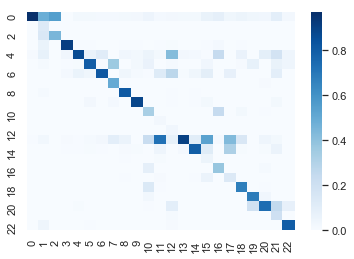

Batch 3050: Training accuracy: 0.8904272317886353 Loss: 0.39449039101600647
Batch 3100: Training accuracy: 0.8929529786109924 Loss: 0.3884736895561218
Batch 3150: Training accuracy: 0.8923404216766357 Loss: 0.3928752839565277
Batch 3200: Training accuracy: 0.8908110857009888 Loss: 0.3889066278934479
Batch 3250: Training accuracy: 0.8892454504966736 Loss: 0.3932143449783325
Test accuracy: 0.8858906626701355
Weighted P R F S (0.8700679400575005, 0.8324185019077582, 0.8429293408222356, None)
Crop accuracy: 0.8324185019077582
Weighted crop accuracy 0.8493337437015985
weighted all accuracy: 0.9311659282017947 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


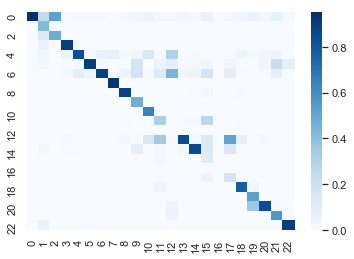

Batch 3300: Training accuracy: 0.8949943780899048 Loss: 0.3768002986907959
Batch 3350: Training accuracy: 0.8891855478286743 Loss: 0.3962950110435486
Batch 3400: Training accuracy: 0.8878318071365356 Loss: 0.38770607113838196
Batch 3450: Training accuracy: 0.8876525163650513 Loss: 0.3884008824825287
Batch 3500: Training accuracy: 0.8976354002952576 Loss: 0.3700365126132965
Test accuracy: 0.8955408334732056
Weighted P R F S (0.8594774782893687, 0.8338581344167937, 0.8435133364451947, None)
Crop accuracy: 0.8338581344167937
Weighted crop accuracy 0.8751884257653412
weighted all accuracy: 0.9536526914451957 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


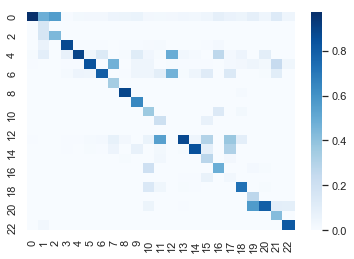

Batch 3550: Training accuracy: 0.8973127603530884 Loss: 0.3734574019908905
Batch 3600: Training accuracy: 0.8956420421600342 Loss: 0.37936076521873474
Batch 3650: Training accuracy: 0.8887081742286682 Loss: 0.3958408236503601
Batch 3700: Training accuracy: 0.8912498950958252 Loss: 0.3939070403575897
Batch 3750: Training accuracy: 0.8948892951011658 Loss: 0.37194979190826416
Test accuracy: 0.890123188495636
Weighted P R F S (0.8424525672059024, 0.8202680183307874, 0.8249373811485413, None)
Crop accuracy: 0.8202680183307874
Weighted crop accuracy 0.8696426046255973
weighted all accuracy: 0.9529720044842113 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


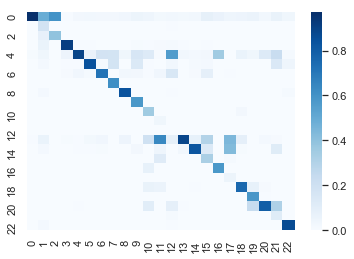

Batch 3800: Training accuracy: 0.8932477831840515 Loss: 0.37661582231521606
Batch 3850: Training accuracy: 0.888722836971283 Loss: 0.39216747879981995
Batch 3900: Training accuracy: 0.8926345705986023 Loss: 0.39769503474235535
Batch 3950: Training accuracy: 0.8941076397895813 Loss: 0.37950852513313293
Batch 4000: Training accuracy: 0.8931318521499634 Loss: 0.3860737979412079
Test accuracy: 0.893235981464386
Weighted P R F S (0.8609147570531583, 0.8427082292603324, 0.8462925666823553, None)
Crop accuracy: 0.8427082292603324
Weighted crop accuracy 0.8872033218576755
weighted all accuracy: 0.946363133722945 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


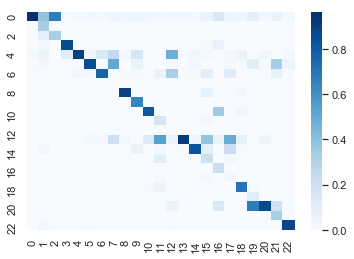

Batch 4050: Training accuracy: 0.8917738199234009 Loss: 0.3769329786300659
Batch 4100: Training accuracy: 0.8957605957984924 Loss: 0.3677862286567688
Batch 4150: Training accuracy: 0.8968372941017151 Loss: 0.36362937092781067
Batch 4200: Training accuracy: 0.8921666741371155 Loss: 0.377610981464386
Batch 4250: Training accuracy: 0.8981192111968994 Loss: 0.37468230724334717
Test accuracy: 0.8832266330718994
Weighted P R F S (0.8330814839283307, 0.8077842030541224, 0.8114126378574578, None)
Crop accuracy: 0.8077842030541224
Weighted crop accuracy 0.8746966206368672
weighted all accuracy: 0.9487048658211313 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


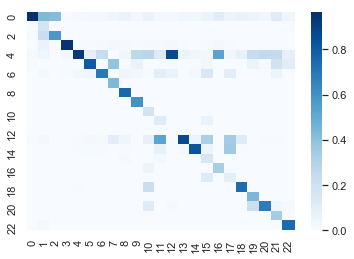

Batch 4300: Training accuracy: 0.8948824405670166 Loss: 0.36221054196357727
Batch 4350: Training accuracy: 0.9001733660697937 Loss: 0.36078858375549316
Batch 4400: Training accuracy: 0.8921296000480652 Loss: 0.3762158155441284
Batch 4450: Training accuracy: 0.8925980925559998 Loss: 0.3679893910884857
Batch 4500: Training accuracy: 0.9033487439155579 Loss: 0.35234105587005615
Test accuracy: 0.8935773968696594
Weighted P R F S (0.8638953950107715, 0.8317209429077531, 0.8366227722953188, None)
Crop accuracy: 0.8317209429077531
Weighted crop accuracy 0.8641641397827468
weighted all accuracy: 0.9495665253418472 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


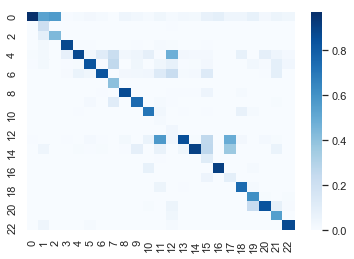

Batch 4550: Training accuracy: 0.893688440322876 Loss: 0.37023812532424927
Batch 4600: Training accuracy: 0.8923901319503784 Loss: 0.3753091096878052
Batch 4650: Training accuracy: 0.8955093622207642 Loss: 0.37812966108322144
Batch 4700: Training accuracy: 0.8954437375068665 Loss: 0.3645121455192566
Batch 4750: Training accuracy: 0.8959594964981079 Loss: 0.3685518205165863
Test accuracy: 0.8999911546707153
Weighted P R F S (0.8740844676779547, 0.8497808473900916, 0.8585378933173657, None)
Crop accuracy: 0.8497808473900916
Weighted crop accuracy 0.8699516402451027
weighted all accuracy: 0.9472747370253065 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


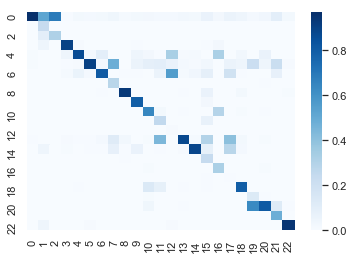

Batch 4800: Training accuracy: 0.9006438255310059 Loss: 0.36258721351623535
Batch 4850: Training accuracy: 0.8993883728981018 Loss: 0.3598206043243408
Batch 4900: Training accuracy: 0.8951339721679688 Loss: 0.3671332895755768
Batch 4950: Training accuracy: 0.8975139856338501 Loss: 0.3609241843223572
Batch 5000: Training accuracy: 0.9025311470031738 Loss: 0.35720959305763245
Test accuracy: 0.8928796648979187
Weighted P R F S (0.8516892935263128, 0.8297812279463656, 0.833719901489299, None)
Crop accuracy: 0.8297812279463656
Weighted crop accuracy 0.8674459697821136
weighted all accuracy: 0.9477171433971082 


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


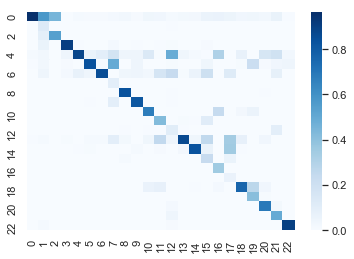

Evaluation accuracy: 0.8880214691162109


/Users/johnbrandt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Weighted P R F S (0.8391842976566107, 0.8213500214706883, 0.8234936819976127, None)
Crop accuracy: 0.8213500214706883
Weighted crop accuracy 0.8651109604808358
weighted all accuracy: 0.9462703384549438 


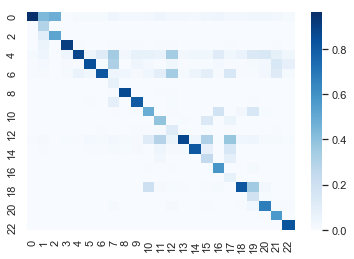

Batch 5050: Training accuracy: 0.8960601687431335 Loss: 0.3751128911972046
Batch 5100: Training accuracy: 0.8988614678382874 Loss: 0.3640720248222351
Batch 5150: Training accuracy: 0.898642897605896 Loss: 0.3525035083293915
Batch 5200: Training accuracy: 0.8972384929656982 Loss: 0.3630898594856262


KeyboardInterrupt: 

In [45]:
saver = tf.train.Saver(max_to_keep = 2)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
    
for key, value in args_dict.items():
    print(key + ": " + str(value))

with tf.Session() as sess:
    #saver.restore(sess, "../models/best2/model.ckpt")
    print("Model restored.")
    tf.global_variables_initializer().run()
    losses, accuracies = [], []
    max_step = 50000
    step = 0
    datagen = data_generator(os.listdir("../data/external/train/"), direct = 'train')
    test_gen = data_generator(os.listdir("../data/external/test/"), direct = 'test')
    eval_gen = data_generator(os.listdir("../data/external/eval/"), direct = 'eval')
    while step < max_step:
        # save_path = saver.save(sess, os.getcwd() + "/model.ckpt")
        X_batch, y_batch, seq_len = next(datagen)
        splits = [x for x in range(0, 481, batch_size)]
        for i in splits:
                step += 1
                minibatch_x = X_batch[i : i + batch_size]
                minibatch_y = y_batch[i : i + batch_size]
                minibatch_len = seq_len[i : i + batch_size]
                feed_dict = {X: minibatch_x, y: minibatch_y, seq_lengths : minibatch_len} 
                _, loss_value, acc = sess.run([train_op, cross_entropy, accuracy], feed_dict)
                accuracies.append(acc)
                losses.append(loss_value)
                if step % 50 == 0:
                    print("Batch {}: Training accuracy: {} Loss: {}".format(step, np.mean(accuracies), np.mean(losses)))
                    losses, accuracies = [], []
        if step % 250 == 0:
            preds, trues, test_acc = [], [], []
            for i in range(0, 5):
                X_batch, y_batch, seq_len = next(test_gen)
                splits = [x for x in range(0, 481, batch_size)]
                for i in splits:
                    minibatch_x = X_batch[i : i + batch_size]
                    minibatch_y = y_batch[i : i + batch_size]
                    minibatch_len = seq_len[i : i + batch_size]
                    feed_dict={X: minibatch_x, y: minibatch_y, seq_lengths : minibatch_len}
                    test_acc.append(sess.run(accuracy, feed_dict = feed_dict))
                    pred, true = sess.run([y_pred, y_true], feed_dict)
                    preds.append(pred)
                    trues.append(true)
            pred = [item for sublist in preds for item in sublist]
            true = [item for sublist in trues for item in sublist]
            print("Test accuracy: {}".format(np.mean(test_acc)))
            calc_crop_acc(pred, true, weight_crop)
            confusion = tf.confusion_matrix(labels=true, predictions=pred, num_classes=23).eval(session=sess)
            make_confusion_plot(confusion)
        #if step % 10000 == 0:
            #save_path = saver.save(sess, "../models/best2/additional_training/model.ckpt")
            #print("Model saved in path: %s" % save_path)
        if step % 2500 == 0:
            preds, trues, test_acc = [], [], []
            for i in range(0, 115):
                X_batch, y_batch, seq_len = next(eval_gen)
                splits = [x for x in range(0, 481, batch_size)]
                for i in splits:
                    minibatch_x = X_batch[i : i + batch_size]
                    minibatch_y = y_batch[i : i + batch_size]
                    minibatch_len = seq_len[i : i + batch_size]
                    feed_dict={X: minibatch_x, y: minibatch_y, seq_lengths : minibatch_len}
                    test_acc.append(sess.run(accuracy, feed_dict = feed_dict))
                    pred, true = sess.run([y_pred, y_true], feed_dict)
                    preds.append(pred)
                    trues.append(true)
            pred = [item for sublist in preds for item in sublist]
            true = [item for sublist in trues for item in sublist]
            print("Evaluation accuracy: {}".format(np.mean(test_acc)))
            calc_crop_acc(pred, true, weight_crop)
            confusion = tf.confusion_matrix(labels=true, predictions=pred, num_classes=23).eval(session=sess)
            make_confusion_plot(confusion)

In [111]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        print(variable)
        print(shape)
        print(len(shape))
        variable_parameters = 1
        for dim in shape:
            print(dim)
            variable_parameters *= dim.value
        print(variable_parameters)
        total_parameters += variable_parameters
    print(total_parameters)

KeyboardInterrupt: 